<a href="https://colab.research.google.com/github/alejandracardonavelasco/ML-/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2 Homework**

 ## **Primary Question: How can we visualize the decision boundary for attributing a new (unlabeled) point to one of the GMM clusters?**

I will use the given code in the lab 2 repository in order to answer the primary question. I will use the "mouse" dataset.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# SECTION 1: Generate the "mouse" dataset
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

# ----------------------------------------------------------------------
# SECTION 2: Initialize EM for 3 Gaussian mixtures
# ----------------------------------------------------------------------
K = 3
np.random.seed(42)  # again for reproducibility

# Mixture weights, means, covariances
pi = np.ones(K) / K
mu = np.random.randn(K, d)
Sigma = np.array([np.eye(d) for _ in range(K)])

# ----------------------------------------------------------------------
# SECTION 3: Define functions for E-step & M-step
# ----------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian pdf value at x, given mean and cov.
    x is (d, ) vector, mean is (d, ), cov is (d, d).
    """
    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def e_step(data, pi, mu, Sigma):
    """
    E-step: compute the responsibilities resp[n, k] = p(z_n=k | x_n, theta).
    """
    N, _ = data.shape
    K = len(pi)
    resp = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            resp[n, k] = pi[k] * gaussian_pdf(data[n], mu[k], Sigma[k])
        resp[n, :] /= np.sum(resp[n, :])  # normalize

    return resp

def m_step(data, resp):
    """
    M-step: given responsibilities, update pi, mu, Sigma.
    """
    N, d_ = data.shape
    K = resp.shape[1]

    Nk = np.sum(resp, axis=0)  # shape (K,)

    # Update pi
    pi_new = Nk / N

    # Update mu
    mu_new = np.zeros((K, d_))
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k].reshape(-1,1)*data, axis=0) / Nk[k]

    # Update Sigma
    Sigma_new = []
    for k in range(K):
        S_k = np.zeros((d_, d_))
        for n in range(N):
            diff = data[n] - mu_new[k]
            S_k += resp[n, k] * np.outer(diff, diff)
        S_k /= Nk[k]
        Sigma_new.append(S_k)
    Sigma_new = np.array(Sigma_new)

    return pi_new, mu_new, Sigma_new


Now, we generate the decision boundary visualization. We are going to define a grid and compute the responsibilities for each grid point. Once we have these probabilities, we will assign each point to the most likely cluster.

In [4]:
# Generate decision boundary visualization

# Define grid for visualization
x_min, x_max = data_X[:, 0].min() - 0.5, data_X[:, 0].max() + 0.5
y_min, y_max = data_X[:, 1].min() - 0.5, data_X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute responsibilities (posterior probabilities) for each grid point
resp_grid = e_step(grid_points, pi, mu, Sigma)

# Assign each grid point to the most likely cluster
cluster_assignments = np.argmax(resp_grid, axis=1)
cluster_assignments = cluster_assignments.reshape(xx.shape)


Now we will plot the decision boundary including the cluster centers.

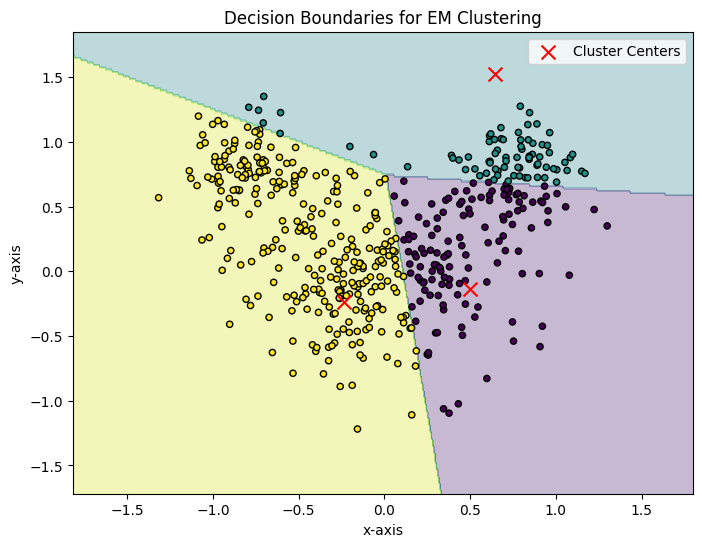

In [5]:
# Plot the decision boundary

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, cluster_assignments, alpha=0.3, cmap='viridis')

# Plot data points with true labels
resp = e_step(data_X, pi, mu, Sigma)
plt.scatter(data_X[:, 0], data_X[:, 1], c=np.argmax(resp, axis=1), cmap='viridis', s=20, edgecolors='k')

# Plot cluster centers
plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Decision Boundaries for EM Clustering")
plt.legend()
plt.show()

 **Irregularities:**
 The decision boundaries in the plot show some irregularities. The transitions between clusters are sharp, which could be due to poor initialization. Also, the upper-left region is assigned to a distant cluster, likely due to an overestimated variance. The cluster centers, marked with red "X", do not perfectly align with the densest areas, which is a result of random initialization.

 ## **Secondary Question: If we didn't know the number of clusters in advance, how could we decide on a suitable K for the clustering algorithm?**

To decide a suitable K, one good approach could be trying different values of K and calculate its **overall shilouette score**. The most reasonable cluster will be the one with the shilouette score closest to 1. I will use a library to calculate it.

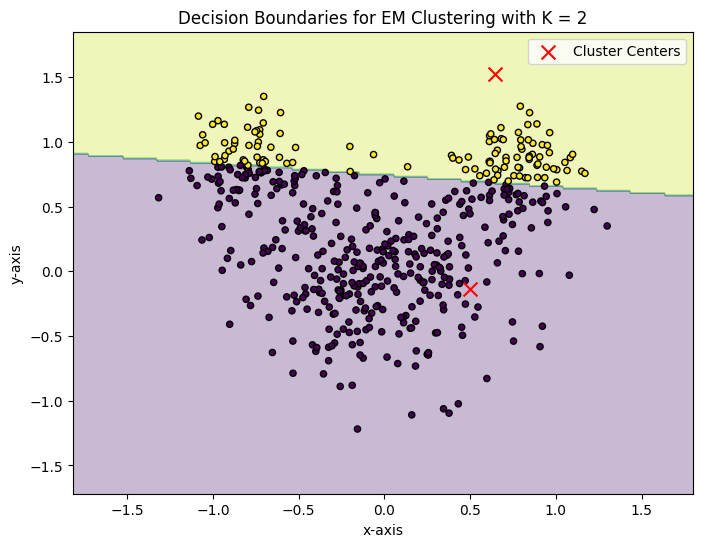

shilouette score =  0.2777930593018624


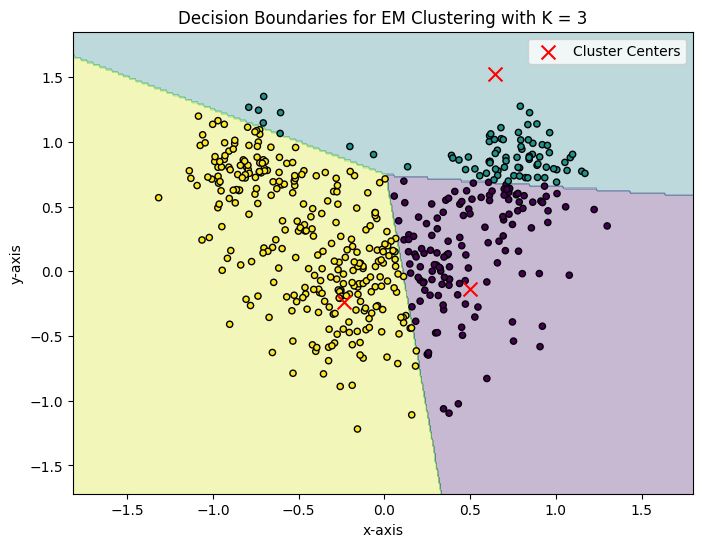

shilouette score =  0.289759772912485


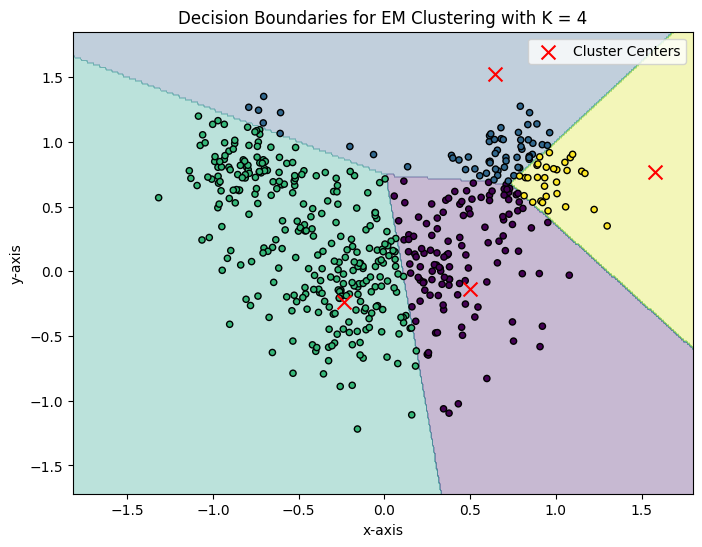

shilouette score =  0.2206483739491919


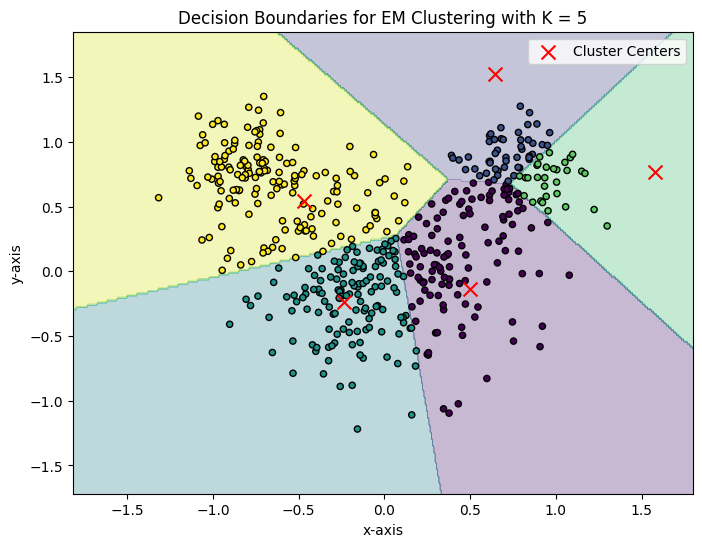

shilouette score =  0.3375944251823023


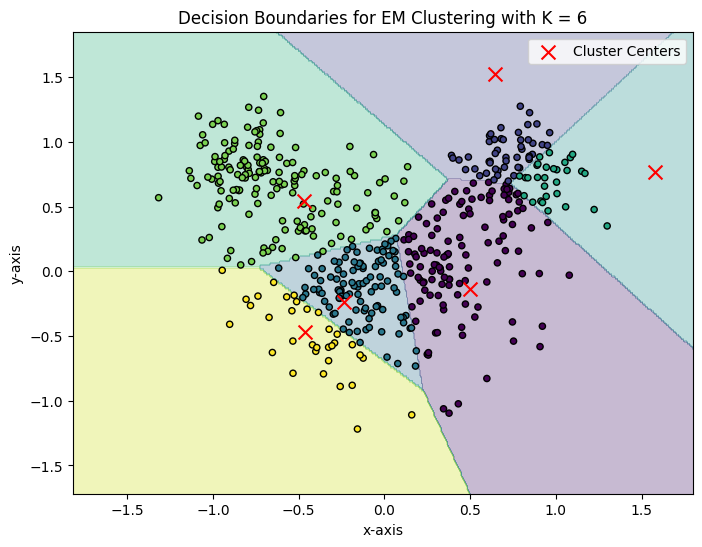

shilouette score =  0.284180990340788


In [18]:
scores = []
for K in range(2,7):

    np.random.seed(42)  # for reproducibility

    # Mixture weights, means, covariances
    pi = np.ones(K) / K
    mu = np.random.randn(K, d)
    Sigma = np.array([np.eye(d) for _ in range(K)])

    # Generate decision boundary visualization

    # Define grid for visualization
    x_min, x_max = data_X[:, 0].min() - 0.5, data_X[:, 0].max() + 0.5
    y_min, y_max = data_X[:, 1].min() - 0.5, data_X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Compute responsibilities (posterior probabilities) for each grid point
    resp_grid = e_step(grid_points, pi, mu, Sigma)

    # Assign each grid point to the most likely cluster
    cluster_assignments = np.argmax(resp_grid, axis=1)
    cluster_assignments = cluster_assignments.reshape(xx.shape)

    # Plot the decision boundary

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, cluster_assignments, alpha=0.3, cmap='viridis')

    # Plot data points with true labels
    resp = e_step(data_X, pi, mu, Sigma)
    plt.scatter(data_X[:, 0], data_X[:, 1], c=np.argmax(resp, axis=1), cmap='viridis', s=20, edgecolors='k')

    # Plot cluster centers
    plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.title(f"Decision Boundaries for EM Clustering with K = {K}")
    plt.legend()
    plt.show()

    # We calculate the shilouette score using some libraries
    from sklearn.metrics import silhouette_score

    labels = np.argmax(e_step(data_X, pi, mu, Sigma), axis=1)
    silhouette_score = silhouette_score(data_X, labels)
    scores.append(silhouette_score)
    print("shilouette score = ", silhouette_score)

We plot the different silhouette scores for each K.

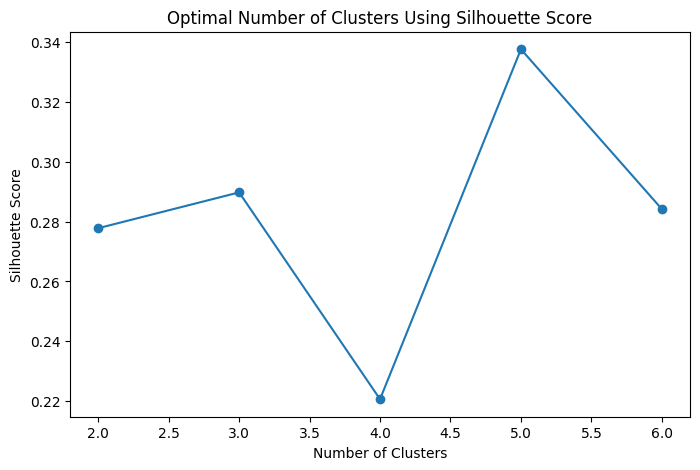

In [16]:
# Plot silhouette scores
k_values = range(2, 7)
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters Using Silhouette Score")
plt.show()

In this case we see that the optimal number of clusters is 5 because it has the shilouette score closest to 1.